# Import libraries

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt
import time
from tensorflow.keras.optimizers import Adam

# Load and process images

In [23]:
# Function to load and process images
def load_and_process_image(img_path, max_dim=512):
    img = Image.open(img_path)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.LANCZOS)  
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to de-process image (reverse preprocessing for visualization)
def deprocess_image(processed_img):
    x = processed_img.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [25]:
content_image_path = "C:\\Users\\geeth\\Downloads\\gettyimages-822273028-612x612.jpg"
style_image_path = "C:\\Users\\geeth\\Downloads\\download (7).jpeg"

content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

# Layers for style and content representation

In [27]:
content_layers = ['block5_conv2']  # layer for content extraction
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']  # layers for style

# Model configuration
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    model_outputs = style_outputs + content_outputs
    return Model(vgg.input, model_outputs)

# Computing loss

In [29]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [31]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0

    # Calculate style loss
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Calculate content loss
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight
    content_score *= content_weight
    total_loss = style_score + content_score 
    return total_loss, style_score, content_score

# Extracting feature representations from the VGG19 model for content and style images

In [33]:
def get_feature_representations(model, content_image, style_image):
    content_outputs = model(content_image)
    style_outputs = model(style_image)
    
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

# Compute gradients for the neural style transfer optimization

In [35]:
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Run the style transfer

In [37]:
def run_style_transfer(content_path, 
                       style_path, 
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    
    # Load and process images
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    # Get feature representations of our images
    style_features, content_features = get_feature_representations(model, content_image, style_image)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Setup initial image (content_image) and make it trainable
    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = Adam(learning_rate=5.0)
    
    # Create config for loss computation
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
     # Optimization loop
    best_loss, best_img = float('inf'), None
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, -128, 128)
        init_image.assign(clipped)
        
        # Update best loss and image
        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()
        
        # Print progress
        if i % 100 == 0:
            print(f"Iteration: {i}, Total loss: {loss}, Style loss: {style_score}, Content loss: {content_score}")
    
    return best_img, best_loss

## Content Image: Mount Fuji 
## Style Image: Abstract painting 

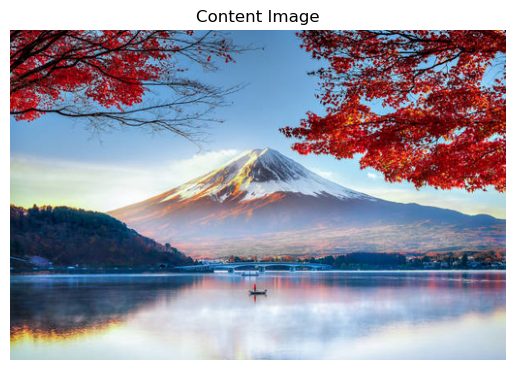

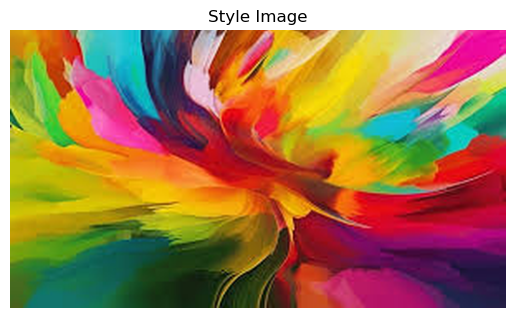

In [39]:
# Load and process images
content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

# Function to display the images
def show_image(img, title=None):
    img = np.squeeze(img, axis=0)  # Remove batch dimension
    img = deprocess_image(img)  # De-process for display

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display the content and style images
show_image(content_image, title="Content Image")
show_image(style_image, title="Style Image")

Iteration: 0, Total loss: 330251968.0, Style loss: 330251968.0, Content loss: 0.0
Iteration: 100, Total loss: 4302727.0, Style loss: 2522261.0, Content loss: 1780465.875
Iteration: 200, Total loss: 3462843.0, Style loss: 2019250.25, Content loss: 1443592.625
Iteration: 300, Total loss: 2470367.5, Style loss: 1203677.875, Content loss: 1266689.625
Iteration: 400, Total loss: 2973372.5, Style loss: 1740572.75, Content loss: 1232799.75
Iteration: 500, Total loss: 2258102.5, Style loss: 1132230.0, Content loss: 1125872.625
Iteration: 600, Total loss: 3098349.0, Style loss: 1581434.25, Content loss: 1516914.875
Iteration: 700, Total loss: 2186060.25, Style loss: 1010945.1875, Content loss: 1175115.0
Iteration: 800, Total loss: 2030668.5, Style loss: 933599.1875, Content loss: 1097069.375
Iteration: 900, Total loss: 1819036.125, Style loss: 796901.75, Content loss: 1022134.375
Iteration: 1000, Total loss: 1771933.125, Style loss: 781558.125, Content loss: 990375.0
Iteration: 1100, Total loss

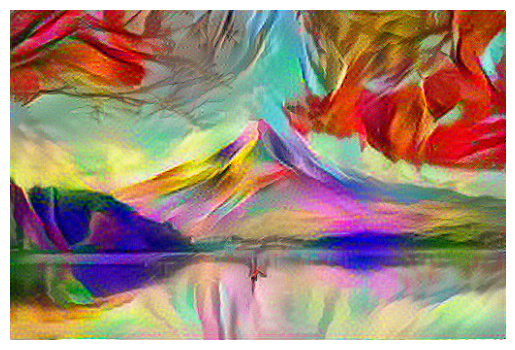

In [41]:
best_img, best_loss = run_style_transfer(content_image_path, style_image_path, num_iterations=3000)

# Convert and display final image
final_img = deprocess_image(best_img[0])
plt.imshow(final_img)
plt.axis('off')
plt.show()